In [1]:
import numpy as np
import scipy as sp
import pyhf
import cabinetry
import redist
import matplotlib.pyplot as plt

np.random.seed(12)

# Reinterpetation with [`redist`](https://github.com/lorenzennio/redist)

<p align="center">
  <img src="fig/logo.svg"  width="600"/>
</p>

**redist** performs histogram reweighting based on differences in kinematic distributions. It is built to operate in combination with [pyhf](https://pyhf.readthedocs.io).

**Check out the paper [here](https://arxiv.org/pdf/2402.08417.pdf).**

## Measuring the $A \to B C D$ decay

We want to measure the decay $A \to B C D$, which has a single kinematic degree of freedom $z$. 

### Simulate some data

We expect the **signal** to be normally distributed according to the PDF
$$
p(z) = \mathcal{N}(z|\mu=4, \sigma=1.5)
$$
and our **background** to be distributed according to the PDF
$$
p(z) = \frac{1}{5}e^{-z/5}.
$$

We expect 10 times more background than signal, so we simulate

- 10k signal events,
- 100k background events.

We also need to simulate our detector. It accepts 10% of events at random and smears our kinematic variable $z$ normally, with $\sigma=1$.

In [2]:
mean = 4.

sig_samples_gen = sp.stats.norm.rvs( loc=mean, scale=1.5, size= 10000)
bkg_samples_gen = sp.stats.expon.rvs(loc=0, scale=5., size=100000)

def detector(z):
    acceptance = np.random.rand(*np.shape(z)) > 0.9
    resolution = sp.stats.norm.rvs(z)
    return resolution[acceptance], z[acceptance]

sig_samples_detector, sig_samples = detector(sig_samples_gen)
bkg_samples_detector, bkg_samples = detector(bkg_samples_gen)

We decide that the reconstructed kinematic variable, after considering detector effects $x \sim \varepsilon(x|z)$ distinguishes signal and background distributions well for $0<x<10$ and chose it as a fitting variable.

In [3]:
bins = np.arange(0,10)

# We only want to keep the events with physical values for z
sig_samples_detector[(sig_samples < bins[0]) | (sig_samples > bins[-1])] = -1
bkg_samples_detector[(bkg_samples < bins[0]) | (bkg_samples > bins[-1])] = -1

sig_hist, _ = np.histogram(sig_samples_detector, bins=bins)
bkg_hist, _ = np.histogram(bkg_samples_detector, bins=bins)

Let's see how our detector changed the shape of our distributions.

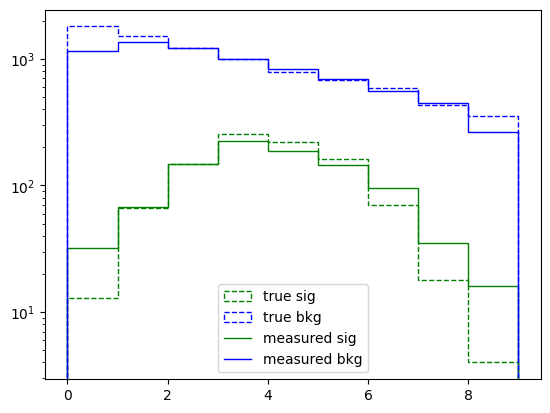

In [4]:
plt.hist(sig_samples, bins=bins, histtype='step', color='g', linestyle='dashed',label='true sig')
plt.hist(bkg_samples, bins=bins, histtype='step', color='b', linestyle='dashed',label='true bkg')

plt.stairs(sig_hist, color='g', label='measured sig')
plt.stairs(bkg_hist, color='b', label='measured bkg')

plt.yscale('log')
plt.legend()
plt.show()

### Get some data from our detector

We are now ready to look at some "real" data. 

We find that in reality, our signal is actually distributed according to the PDF
$$
p(z) = \mathcal{N}(z|\mu=5, \sigma=1.5).
$$
In addition, there are actually twice as many signal events, as expected. 

In [5]:
mean_true = 5.
scale_true = 2.

sig_samples_data = sp.stats.norm.rvs(loc=mean_true, scale=1.5, size= 10000)
bkg_samples_data = sp.stats.expon.rvs(scale=5., size=100000)

sig_samples_data, _ = detector(sig_samples_data)
bkg_samples_data, _ = detector(bkg_samples_data)

sig_hist_data, _ = np.histogram(sig_samples_data, bins=bins)
bkg_hist_data, _ = np.histogram(bkg_samples_data, bins=bins)

data = (bkg_hist_data + sig_hist_data * scale_true).tolist()

# Statistical inference with [`pyhf`](https://pyhf.readthedocs.io/en/v0.7.6/intro.html)

[`pyhf`](https://pyhf.readthedocs.io/en/v0.7.6/intro.html) ( = HistFactory in python) has become a common analysis tool for statistical inference.

It is based on maximum likelihood estimation with the (very simplified) likelihood function for observed event counts $\boldsymbol{n}$

$$
    L(\boldsymbol{n}, \boldsymbol{a} \mid \boldsymbol{\eta}, \boldsymbol{\chi})=\underbrace{\operatorname{Pois}\left(
    \boldsymbol{n} \mid 
    \boldsymbol{\nu}(\boldsymbol{\eta}, \boldsymbol{\chi})
    \right)}_{\text{data likelihood}}
    \underbrace{c\left(\boldsymbol{a} \mid \boldsymbol{\chi} \right)}_{\text{constraint likelihood}}.
$$

The expected number of events are

$$  
    \boldsymbol{\nu}\left(\boldsymbol{\eta}, \boldsymbol{\chi}\right)
    =
    \boldsymbol{\kappa}(\boldsymbol{\eta}, \boldsymbol{\chi})
    \left(
    \boldsymbol{\nu}^0(\boldsymbol{\eta}, \boldsymbol{\chi})+\boldsymbol{\Delta}(\boldsymbol{\eta}, \boldsymbol{\chi})
    \right) .
$$

We construct our statistical model and add a Poisson error for our background. We use [`cabinetry`](https://cabinetry.readthedocs.io/en/latest/) for visualization here. It also calculates the correct uncertainties for us.

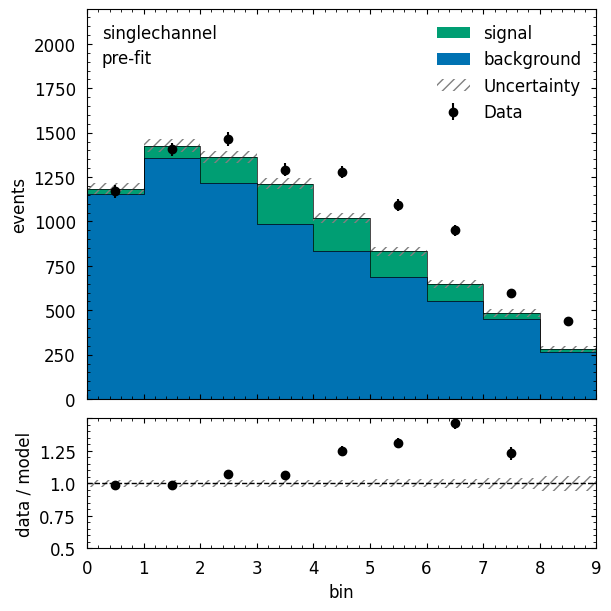

In [6]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=sig_hist.tolist(), 
    bkg=bkg_hist.tolist(), 
    bkg_uncertainty=np.sqrt(bkg_hist).tolist()
)

model_pred_prefit = cabinetry.model_utils.prediction(model)
cabinetry.visualize.data_mc(model_pred_prefit, data);

That does not look too good yet.

Maybe after fitting, things will look better?

mu: 2.230 +/- 0.122
uncorr_bkguncrt[0]: 0.977 +/- 0.021
uncorr_bkguncrt[1]: 0.964 +/- 0.020
uncorr_bkguncrt[2]: 0.971 +/- 0.022
uncorr_bkguncrt[3]: 0.922 +/- 0.026
uncorr_bkguncrt[4]: 1.014 +/- 0.029
uncorr_bkguncrt[5]: 1.048 +/- 0.032
uncorr_bkguncrt[6]: 1.144 +/- 0.036
uncorr_bkguncrt[7]: 1.072 +/- 0.036
uncorr_bkguncrt[8]: 1.247 +/- 0.050


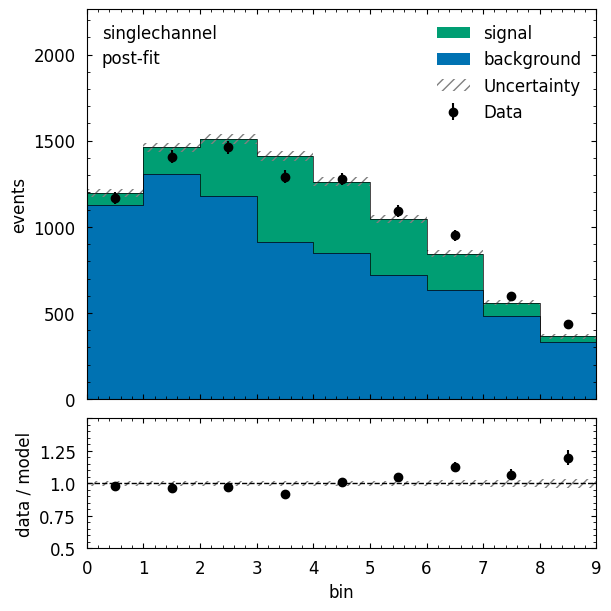

In [7]:
fit_results = cabinetry.fit.fit(model, data + model.config.auxdata)
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")
    
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
cabinetry.visualize.data_mc(model_pred_postfit, data);

Nice, we got the scale factor correct! But would you really trust a best fit result that looks like this?

To make things better, we decide that the signal PDF might not be the correct one. It would be great if we could leave the mean free floating here and also learn something about this parameter:
$$
p(z|m) = \mathcal{N}(z|\mu=m, \sigma=1.5).
$$

In reality there is no easy way to do this. You would have to
1. Pick an alternative value for $m$,
2. Generate new MC samples,
3. Simulate the detector response to each of the samples,
4. Redo the statistical analysis,

and repeat this until you found a good value for $m$. 

Phu...

What about a better way?

# The [`redist`](https://github.com/lorenzennio/redist) reinterpretation method

After reconstruction you obtain a number-density $n(x)$ for all channels, in a reconstruction/fitting variable $x$. 

Stacking all signal and background contributions, this is what we compare to the data.

When producing MC samples, we made a choice - the theoretical prediction 
$$
    \sigma(z) = \sigma p(z)
$$
in the kinematic variable(s) $z$.

<p align="center">
  <img src="fig/redist.drawio.svg"  width="800"/>
</p>

The number density $n(x)$ and the theoretical prediction $\sigma(z)$ are connected via
$$
    n(x) = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma(z)
$$
where we fold the theoretical prediction with the conditional reconstruction and selection efficiency $\varepsilon(x|z)$ and scale by the corresponding luminosity $L$.

Futher, we can define the **joint number density** 
$$
n(x,z) = L ~ \varepsilon(x|z) ~ \sigma(z).
$$

<p align="center">
  <img src="fig/redist-rw.drawio.svg"  width="400"/>
</p>

With this object alone, we can obtain the bin yields $n_B(x)$ of an alternative prediction $\sigma_B(z)$,
$$
    n_B(x)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_B(z)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_A(z) ~ \frac{\sigma_B(z)}{\sigma_A(z)}
        = \sum_z ~ n_A(x,z) ~ w(z).
$$
Here, the weights $w(z)$ are the ratio of the bin integrated kinematic predictions. 

Analysts can easily compute the joint number density $n_A(x,z)$ for their underlying theory with a kinematic prediction $\sigma_A(z)$ from the MC samples.

Let us apply this to our example!

## Implementation details
Recall how [`pyhf`](https://pyhf.readthedocs.io/en/v0.7.6/intro.html) calculates the expected number of events,

$$  
    \boldsymbol{\nu}\left(\boldsymbol{\eta}, \boldsymbol{\chi}\right)
    =
    \boldsymbol{\kappa}(\boldsymbol{\eta}, \boldsymbol{\chi})
    \left(
    \boldsymbol{\nu}^0(\boldsymbol{\eta}, \boldsymbol{\chi})+\boldsymbol{\Delta}(\boldsymbol{\eta}, \boldsymbol{\chi})
    \right) .
$$

We introduce a new bin-wise, multiplicative modifier 

$$
    \boldsymbol{\kappa}(x | \boldsymbol{\eta}, \boldsymbol{\chi}) = \frac{n_B(x|\boldsymbol{\eta}, \boldsymbol{\chi})}{n_A (x|\boldsymbol{\eta}, \boldsymbol{\chi})}.
$$

## Kinematic distributions

First, let us define the theory predictions of our null hypothesis,
$$
    \sigma_{A}(z) = \mathcal{N}(z|\mu=4, \sigma=1.5).
$$

Next we define the kinematic prediction for our alternative hypothesis:
- We want a free floating $m$ parameter. 
- In addition, based on your previous knowledge, we incorporate the scaling factor of 2 into the new model as well
$$
\sigma_{B}(z|m) = 2 \cdot \mathcal{N}(z|\mu=m, \sigma=1.5).
$$

(Only the relative scaling matters here.)

In [8]:
def sigma_A(x):
    return sp.stats.norm.pdf(x, loc=4., scale=1.5)

def sigma_B(x, mu):
    scale = 2.
    return scale*sp.stats.norm.pdf(x, loc=mu, scale=1.5)

## Create the joint number densities

Creating the joint number density object is easy - it is just a 2d histogram.

We can make use of the `redist.modifier.map()` function to place our samples in the correct bins.

For simplicity let us use the same binning for our kinematic degree of freedom $z$, as we used for our reconstruction variable $x$.

In [9]:
joint_nr_dens = redist.modifier.map(
    sig_samples_detector,   # x
    [sig_samples],          # z
    bins, 
    [bins]
    )

## Set up the modifier $\boldsymbol{\kappa}(x | \boldsymbol{\eta}, \boldsymbol{\chi})$

Next we can define the modifier that will reweight our histograms internally, initialized with the `redist.modifier.Modifier()`.

So we only need to define our new parameter $m$ in a dictionary. Your theory friend tells you $m=3.5$ is a good choice (everyone can be wrong sometimes):

In [10]:
new_params = {
    'm' :{'inits': (3.5,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
    }

kappa = redist.modifier.Modifier(
    new_params, 
    sigma_B, 
    sigma_A, 
    joint_nr_dens, 
    [bins], 
    name="vary_m"
    )

## Visualization

We can visualize the kinematic predictions, including weights with `redist.plot.dists()` and the joint number density with `redist.plot.map()`.

(<Figure size 1400x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

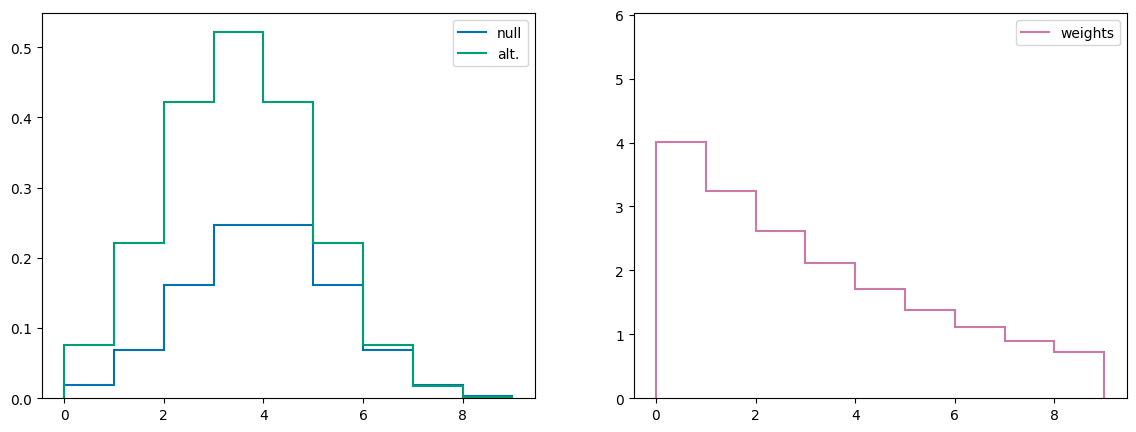

In [11]:
m = [3.5]
redist.plot.dists(kappa, m, plot_weights=True)

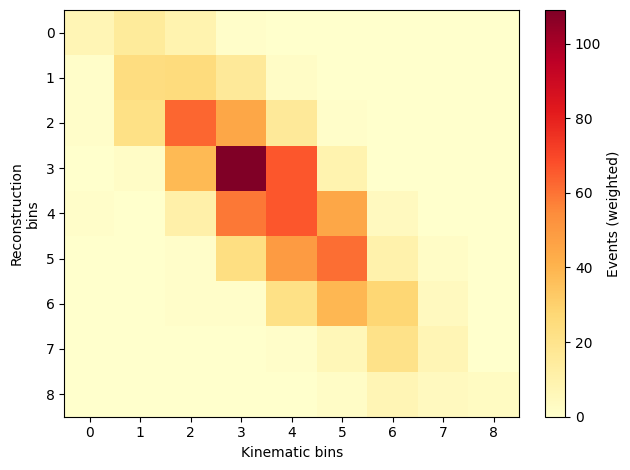

In [12]:
redist.plot.map(kappa, cmap='YlOrRd', aspect='auto');

## Adding to the statistical model

To add this to our existing `pyhf.Model`, we can use the helper function `redist.modifier.add_to_model()`. 

Let us have a look at the model parameters now afterwards.

In [13]:
kappa_specs = {
                "name": "signal_vary_m",
                "type": "vary_m", # the name of the modifier, provided above 
                "data":
                    {
                        "expr": "vary_m_weight_fn", 
                        # the name of the custom function assigned in 
                        # global namespace = modifier.name + '_weight_fn'
                    }
              }

model = redist.modifier.add_to_model(model, ['singlechannel'], ['signal'], kappa.expanded_pyhf, kappa_specs)

model.config.par_names

['m',
 'mu',
 'uncorr_bkguncrt[0]',
 'uncorr_bkguncrt[1]',
 'uncorr_bkguncrt[2]',
 'uncorr_bkguncrt[3]',
 'uncorr_bkguncrt[4]',
 'uncorr_bkguncrt[5]',
 'uncorr_bkguncrt[6]',
 'uncorr_bkguncrt[7]',
 'uncorr_bkguncrt[8]']

## Fit the parameters

We can fit directly for $m$ now:

m: 5.131 +/- 0.123
mu: 1.113 +/- 0.057
uncorr_bkguncrt[0]: 0.999 +/- 0.021
uncorr_bkguncrt[1]: 0.996 +/- 0.020
uncorr_bkguncrt[2]: 1.034 +/- 0.023
uncorr_bkguncrt[3]: 0.980 +/- 0.027
uncorr_bkguncrt[4]: 1.016 +/- 0.030
uncorr_bkguncrt[5]: 0.989 +/- 0.032
uncorr_bkguncrt[6]: 1.011 +/- 0.037
uncorr_bkguncrt[7]: 0.947 +/- 0.038
uncorr_bkguncrt[8]: 1.068 +/- 0.055


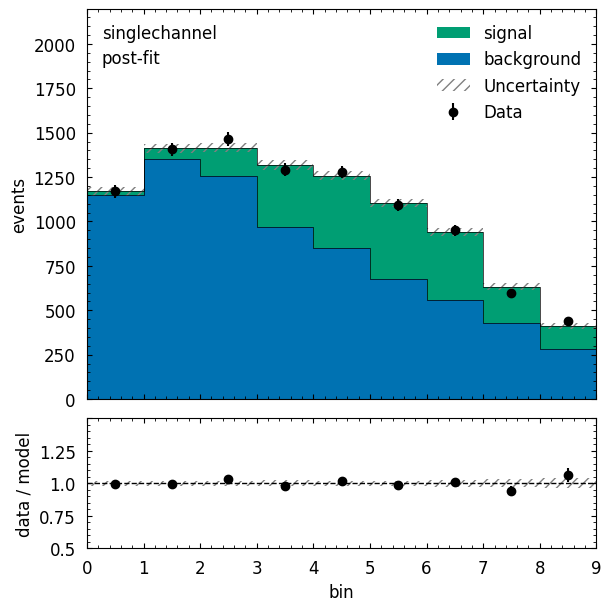

In [14]:
fit_results= cabinetry.fit.fit(model, data + model.config.auxdata)
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data)

Great, we managed to actually find the correct value for $m$ AND $\mu$ -- and a much better fit. 

# Not shown today

- Save to `json`: `redist.modifier.save()` 
  
- Load from `json`: `redist.modifier.load()`

- Correlated parameters
  ```
  new_params = {'f' :{'inits': (f1, f2, ...), 'bounds': ..., 'cov': ..., 'paramset_type': ...}}
  ```

- Combination of models: `redist.modifier.combine()`



# Summary

- [`redist`](https://github.com/lorenzennio/redist) is an **implementation** of the presented reinterpretation method.
  
- It allows for **fast** reinterpretation with minimal additional information.

- This enables **bias free** inference of shape changing parameters.

- Only requires publishing the statistical model & the joint number density.

- [`redist`](https://github.com/lorenzennio/redist) is built to work with [`pyhf`](https://pyhf.readthedocs.io/en/v0.7.6/intro.html).

- The method is more widely applicable. It would be great to see this work with other tools. Should be easy with e.g. [zfit](https://zfit.readthedocs.io/en/stable/).

# Bonus: Posterior estimation with [`bayesian_pyhf`](https://github.com/malin-horstmann/bayesian_pyhf)

One can construct a posterior model simply from [`pyhf`](https://pyhf.readthedocs.io/en/v0.7.6/intro.html) likelihood:
$$
    p\left( \boldsymbol{\eta}, \boldsymbol{\chi} \vert \boldsymbol{n}, \boldsymbol{a} \right) \propto 
    \underbrace{\operatorname{Pois}\left(
    \boldsymbol{n} \mid 
    \boldsymbol{\nu}(\boldsymbol{\eta}, \boldsymbol{\chi})
    \right)}_{\text{data likelihood}} 
    \underbrace{p\left( \boldsymbol{\chi} | \boldsymbol{a} \right)}_{\text{constraint prior}}
    \underbrace{p\left( \boldsymbol{\eta} \right)}_{\text{unconstraint prior}}.
$$

With [`bayesian_pyhf`](https://github.com/malin-horstmann/bayesian_pyhf) we can sample from this posterior and obtain an estimate for it.

In [15]:
from bayesian_pyhf import infer
import pymc as pm
import arviz as az
import corner

In [16]:
# This takes a few minutes to run - you can just load the results below

unconstr_priors = {
    'mu': {'type': 'Uniform_Unconstrained', 'lower': [0.], 'upper': [10.]},
    'm' : {'type': 'Uniform_Unconstrained', 'lower': [0.], 'upper': [10.]}
}

n_draws = 5000

with infer.model(model, unconstr_priors, data):
    post_data = pm.sample(draws=n_draws, chains=4, cores=4)

post_data.to_json( f'post_data.json')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [m]
>Metropolis: [mu]
>Metropolis: [uncorr_bkguncrt]


/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 186 seconds.


'post_data.json'

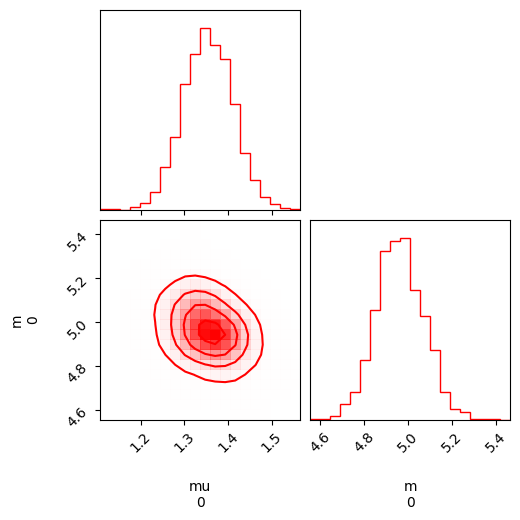

In [17]:
post_data = az.from_json('post_data.json')
corner.corner(
    post_data.posterior, 
    var_names=['mu', 'm'], 
    smooth=1, 
    color='r', 
    plot_datapoints=False
    );